# 架构

从高层次来看，这些系统的步骤如下：

1.	将问题转换为SQL查询：模型将用户输入转换为SQL查询。

2.	执行SQL查询：执行查询。

3.	回答问题：模型根据查询结果响应用户输入。

![image.png](https://python.langchain.com/assets/images/sql_usecase-d432701261f05ab69b38576093718cf3.png)

# 样本数据

下载样本数据：
```
curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
```
现在，Chinook.db 位于我们的目录中，我们可以使用 SQLAlchemy 驱动的 SQLDatabase 类与它进行交互：

In [189]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:////Users/zhengjie/Documents/learn-langchain/example-data/Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

# 链
链条是可预测步骤的组合。在 LangGraph 中，我们可以通过简单的节点序列来表示链条。让我们创建一个步骤序列，给定一个问题，执行以下操作：

1.	将问题转换为 SQL 查询；

2.	执行查询；

3.	使用结果回答原始问题。

这个安排并不支持所有场景。例如，系统会对任何用户输入执行 SQL 查询——即使是“你好”。值得注意的是，正如我们下面将看到的，有些问题需要多次查询才能回答。我们将在“代理”部分解决这些场景。

## 应用状态

我们应用的 LangGraph 状态控制着输入到应用程序的数据、在步骤之间传递的数据以及应用程序输出的数据。它通常是一个 TypedDict，也可以是一个 Pydantic BaseModel。

对于这个应用，我们可以只跟踪输入的问题、生成的查询、查询结果和生成的答案：

In [ ]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

现在我们只需要一些函数来操作这个状态并填充其内容。

## 将问题转换为 SQL 查询

第一步是将用户输入转换为 SQL 查询。为了可靠地获取 SQL 查询（不包括 Markdown 格式的说明或解释），我们将利用 LangChain 的结构化输出抽象。

In [126]:
from config import *
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='deepseek-v3')

我们将从 [Prompt Hub](https://smith.langchain.com/hub?organizationId=5d6d9a77-6e62-5585-a828-231c6537f764) 中获取一个提示，来指导模型。

In [127]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

/Users/zhengjie/Documents/learn-langchain/venv/lib/python3.9/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


这个提示包含了我们需要填充的几个参数，例如 SQL 方言和表模式。LangChain 的 SQLDatabase 对象包含了一些方法来帮助我们处理这些。我们的 write_query 步骤将只填充这些参数并提示模型生成 SQL 查询：

In [128]:
from pydantic import BaseModel
from typing_extensions import Annotated

from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import PydanticOutputParser


class QueryOutput(BaseModel):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


parser = PydanticOutputParser(pydantic_object=QueryOutput)

query_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', '{format_instructions}'),
        query_prompt_template
    ]
).partial(format_instructions=parser.get_format_instructions())


def write_query(state: State):
    """Generate SQL query to fetch information."""

    prompt = query_prompt.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )

    chain = llm | parser
    result = chain.invoke(prompt)

    return {"query": result.query}

看一下query_prompt的内容：

In [159]:
for message in query_prompt.messages:
    message.pretty_print()

================================ System Message ================================

{format_instructions}
================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


让我们测试一下：

In [129]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}

## 执行查询

这是创建 SQL 链条中最危险的部分。在自动执行查询之前，请仔细考虑是否可以对数据运行自动化查询。尽可能减少数据库连接权限。考虑在查询执行之前在链条中添加人工批准步骤（见下文）。

为了执行查询，我们将从 langchain-community 加载一个工具。我们的 execute_query 节点只是封装这个工具：

In [130]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

测试一下：

In [131]:
execute_query({'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'})

{'result': '[(8,)]'}

## 生成答案

最后，我们的最后一步是根据从数据库中提取的信息生成问题的答案：

In [132]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

## 使用 LangGraph 进行协调

最后，我们将应用程序编译成一个单一的图形对象。在这种情况下，我们只是将这三步连接成一个单一的序列。

In [133]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

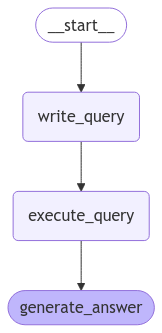

In [134]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

测试一下应用！

In [135]:
for step in graph.stream(
        {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS NumberOfEmployees FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are **8 employees** in total.'}}


## 人工参与

LangGraph 支持许多对这个工作流有用的功能，其中之一就是人工参与：我们可以在敏感步骤（如执行 SQL 查询）之前中断应用程序，以便进行人工审核。这是通过 LangGraph 的持久化层实现的，该层将运行进度保存到您选择的存储中。下面，我们指定了内存存储：

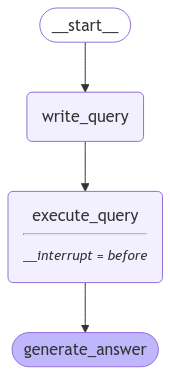

In [144]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

display(Image(graph.get_graph().draw_mermaid_png()))

让我们重复相同的运行，并添加一个简单的 yes/no 审批步骤：

In [145]:
for step in graph.stream(
        {"question": "How many employees are there?"},
        config,
        stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}}
{'__interrupt__': ()}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are **8 employees** in total.'}}


# 代理

代理利用大型语言模型（LLM）的推理能力在执行过程中做出决策。使用代理可以将更多的判断权转移到查询生成和执行过程中。尽管它们的行为比上述“链条”更不可预测，但它们也有一些优势：

•	它们可以根据需要多次查询数据库以回答用户问题。

•	它们可以通过运行生成的查询，捕获回溯并正确地重新生成查询，从而从错误中恢复。

•	它们不仅可以根据数据库的内容回答问题，还可以基于数据库的模式回答问题（比如描述特定的表）。

下面我们组装一个最小的 SQL 代理。

In [160]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x11919bee0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x11919bee0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x11919bee0>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

## 系统提示

我们还需要为我们的代理加载一个系统提示。这将包括行为指令。

In [169]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1

/Users/zhengjie/Documents/learn-langchain/venv/lib/python3.9/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


让我们填充提示中的参数：

In [170]:
system_message = prompt_template.format(dialect="SQLite", top_k=5)
print(system_message)

System: You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see w

## 初始化代理

我们将使用一个预构建的 LangGraph 代理来构建我们的代理。

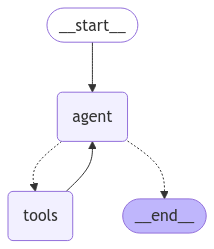

In [212]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="qwen2.5-72b-instruct")
agent_executor = create_react_agent(llm, tools, prompt=system_message)

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [213]:
question = "Which country's customers spent the most?"

result = agent_executor.invoke({"messages": [{"role": "user", "content": question}]})

In [215]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_1c797784083f46b48acd3a)
 Call ID: call_1c797784083f46b48acd3a
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_0372da8207894389b763b6)
 Call ID: call_0372da8207894389b763b6
  Args:
    table_names: Customer, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"

代理会执行多个查询，直到获取所需的信息：
	1.	列出可用的表；
	2.	获取三个表的模式；
	3.	通过联接操作查询多个表。

然后，代理能够使用最终查询的结果来生成原始问题的答案。

代理同样可以处理定性问题：

In [216]:
question = "Describe the playlisttrack table"

result = agent_executor.invoke({"messages": [{"role": "user", "content": question}]})

In [217]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_75e1478ed1a94364a1ba9b)
 Call ID: call_75e1478ed1a94364a1ba9b
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_82a9a0d45346486bbd9ba9)
 Call ID: call_82a9a0d45346486bbd9ba9
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackId") REFE

## 处理高基数列

为了过滤包含专有名词（如地址、歌曲名称或艺术家名字）的列，我们首先需要仔细检查拼写，以便正确地过滤数据。

我们可以通过创建一个包含数据库中所有不同专有名词的向量存储来实现这一点。然后，每当用户在问题中包含专有名词时，代理就可以查询该向量存储，以找到该词的正确拼写。通过这种方式，代理可以确保在构建目标查询之前，理解用户所指的实体。

首先，我们需要获取每个实体的唯一值，为此我们定义一个函数，将结果解析为一个元素列表：

In [190]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['A Soprano Inspired',
 'Carnaval',
 'Van Halen III',
 'Chopin: Piano Concertos Nos.  &',
 'Virtual XI']

使用这个函数，我们可以创建一个检索工具，代理可以根据需要在执行时使用它。

In [191]:
from langchain_community.embeddings import DashScopeEmbeddings

embeddings = DashScopeEmbeddings(model="text-embedding-v3")

选择一个向量存储：

In [192]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

现在我们可以构建一个检索工具，用于在数据库中搜索相关的专有名词：

In [193]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

测试一下：

In [202]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Purcell: The Fairy Queen

Somewhere in Time

Revelations

Amy Winehouse


通过这种方式，如果代理确定需要基于艺术家（例如 “Alice Chains”）写一个过滤器，它可以首先使用检索工具来查看该列的相关值。

将这些步骤整合起来：

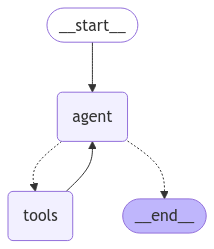

In [218]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, prompt=system)

display(Image(agent.get_graph().draw_mermaid_png()))

In [219]:
question = "How many albums does alis in chain have?"

result = agent.invoke(
    {"messages": [{"role": "user", "content": question}]},
)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================
Tool Calls:
  search_proper_nouns (call_0cdf4d535be34a80889296)
 Call ID: call_0cdf4d535be34a80889296
  Args:
    query: alis in chain
================================= Tool Message =================================
Name: search_proper_nouns

Alice In Chains

A-Sides

In Step

Adams, John: The Chairman Dances

Xis
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_a2dfe77c4a7246cca83260)
 Call ID: call_a2dfe77c4a7246cca83260
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ===============